In [1]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_score, KFold
from cm import plot_confusion_matrix
import pickle

### Prep Training Data

In [2]:
# bring in the participants data
participants_train = pd.read_csv('../data/participants_train.csv')

# bring in the champion_mastery info
champion_mastery = pd.read_csv('../data/champion_mastery.csv')

# merge champion mastery info in
df = pd.merge(participants_train, champion_mastery, on = ['championId', 'summonerId'])

# bring in stats data from the 10-minute mark
stats = pd.read_pickle('../data/ten_min_stats.pkl')#.drop(columns = 'Unnamed: 0')

# Normalize stats values
stats = (
    stats
    .join(pd.json_normalize(stats['position']))
    .drop(columns = 'position')
    .join(pd.json_normalize(stats['champ_stats']))
    .drop(columns = 'champ_stats')
    .join(pd.json_normalize(stats['damage_stats']))
    .drop(columns = 'damage_stats')
)
# merge in stats
df = (
    pd.merge(df, 
             stats, 
             on = ['matchId', 'participantId'])
)

In [3]:
# Dataframe with normalized stats 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78269 entries, 0 to 78268
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   matchId                        78269 non-null  int64 
 1   teamId                         78269 non-null  int64 
 2   participantId                  78269 non-null  int64 
 3   summonerId                     78269 non-null  int64 
 4   summonerLevel                  78269 non-null  int64 
 5   championName                   78269 non-null  object
 6   championId                     78269 non-null  int64 
 7   championLevel                  78269 non-null  int64 
 8   championPoints                 78269 non-null  int64 
 9   chestGranted                   78269 non-null  bool  
 10  tokensEarned                   78269 non-null  int64 
 11  total_gold                     78269 non-null  int64 
 12  xp                             78269 non-null  int64 
 13  l

In [4]:

df.head()

,matchId,teamId,participantId,summonerId,summonerLevel,championName,championId,championLevel,championPoints,chestGranted,...,magicDamageTaken,physicalDamageDone,physicalDamageDoneToChampions,physicalDamageTaken,totalDamageDone,totalDamageDoneToChampions,totalDamageTaken,trueDamageDone,trueDamageDoneToChampions,trueDamageTaken
0,0,100,1,0,303,Mordekaiser,82,6,61890,True,...,2062,6225,917,1902,22588,3446,3965,1510,0,0
1,0,100,2,1,616,Sylas,517,5,37664,True,...,2174,4991,47,7771,43236,2471,10014,13944,16,68
2,0,100,3,2,667,Lissandra,127,6,40303,True,...,1101,5579,232,2150,33594,2700,3835,359,359,583
3,0,100,4,3,860,Caitlyn,51,6,96304,True,...,879,21744,2052,1510,21804,2112,2445,0,0,54
4,0,100,5,4,325,Morgana,25,7,608721,True,...,492,547,86,647,5274,1138,1376,0,0,235


In [5]:
# aggregate team stats
team_stats = (
    df
    .groupby(['matchId', 'teamId'])
    .agg(champion_level = ('championLevel', 'sum'),
         champion_points = ('championPoints', 'sum'),
         total_gold = ('total_gold', 'sum'),
         total_xp = ('xp', 'sum'),
         avg_level = ('level', 'mean'),
         phys_d_taken = ('physicalDamageTaken', 'sum'),
         phys_d_done = ('physicalDamageDone', 'sum'),
         participants = ('participantId', 'count'))
    .reset_index()
)

In [6]:
team_stats

,matchId,teamId,champion_level,champion_points,total_gold,total_xp,avg_level,phys_d_taken,phys_d_done,participants
0,0,100,30,844882,14146,17159,6.8,13980,39086,5
1,0,200,30,1450310,17539,18773,7.0,12273,77056,5
2,1,100,33,2227610,17662,17770,6.8,13213,81141,5
3,1,200,25,871583,14816,18028,6.8,14780,72852,5
4,2,100,25,391340,16374,16837,6.4,15370,90056,5
...,...,...,...,...,...,...,...,...,...,...
15649,7997,200,29,1203774,16571,15721,6.6,17420,78257,5
15650,7998,100,26,290251,15543,15853,6.4,15638,33970,5
15651,7998,200,32,703659,18311,18654,7.2,10335,73125,5
15652,7999,100,26,3962209,17058,19319,7.0,12550,87462,5


In [7]:
# check for any teams that are missing participants due to missing data/merging
team_stats.loc[team_stats['participants'] != 5]

,matchId,teamId,champion_level,champion_points,total_gold,total_xp,avg_level,phys_d_taken,phys_d_done,participants
3940,2014,100,24,2913158,17230,13816,7.0,15883,77061,4


In [8]:
# pull out the match with a missing participant, clean up table
team_stats = team_stats.loc[team_stats['matchId'] != 2014].drop(columns = 'participants')

team_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15652 entries, 0 to 15653
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   matchId          15652 non-null  int64  
 1   teamId           15652 non-null  int64  
 2   champion_level   15652 non-null  int64  
 3   champion_points  15652 non-null  int64  
 4   total_gold       15652 non-null  int64  
 5   total_xp         15652 non-null  int64  
 6   avg_level        15652 non-null  float64
 7   phys_d_taken     15652 non-null  int64  
 8   phys_d_done      15652 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 1.2 MB


In [9]:
# separate out the teams for each match so they can be put into the same row
team_100s = team_stats.loc[team_stats['teamId'] == 100].reset_index(drop = True)

team_200s = team_stats.loc[team_stats['teamId'] == 200].reset_index(drop = True)

# merge so that data for both teams is horizontally arranged
model_df = pd.merge(team_100s, team_200s, on = 'matchId', suffixes = ('_100', '_200'))

#bring in and merge the winners data
winners = pd.read_csv('../data/train_winners.csv')

model_df = pd.merge(model_df,
                    winners, 
                    how = 'left',
                    on = 'matchId')

model_df

,matchId,teamId_100,champion_level_100,champion_points_100,total_gold_100,total_xp_100,avg_level_100,phys_d_taken_100,phys_d_done_100,teamId_200,champion_level_200,champion_points_200,total_gold_200,total_xp_200,avg_level_200,phys_d_taken_200,phys_d_done_200,winner
0,0,100,30,844882,14146,17159,6.8,13980,39086,200,30,1450310,17539,18773,7.0,12273,77056,200
1,1,100,33,2227610,17662,17770,6.8,13213,81141,200,25,871583,14816,18028,6.8,14780,72852,200
2,2,100,25,391340,16374,16837,6.4,15370,90056,200,24,665251,17347,17467,6.8,20369,46965,200
3,3,100,28,640810,19247,17562,6.8,19095,86133,200,31,928477,15145,16196,6.4,17490,89493,100
4,4,100,28,645519,16776,18264,7.2,17888,54976,200,21,141851,15385,17194,6.6,13013,99612,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7821,7995,100,30,1243322,19009,18803,7.2,14209,97849,200,30,1411140,14873,16977,6.8,17049,69632,200
7822,7996,100,28,1301721,16413,17298,6.6,15889,58685,200,30,557302,16140,17927,6.8,16481,92023,100
7823,7997,100,29,664485,17745,17090,6.8,13379,74196,200,29,1203774,16571,15721,6.6,17420,78257,200
7824,7998,100,26,290251,15543,15853,6.4,15638,33970,200,32,703659,18311,18654,7.2,10335,73125,200


In [10]:
#Sort Model features
sorted_features = sorted(model_df.columns)

# Feature list for models
sorted_features

['avg_level_100',
 'avg_level_200',
 'champion_level_100',
 'champion_level_200',
 'champion_points_100',
 'champion_points_200',
 'matchId',
 'phys_d_done_100',
 'phys_d_done_200',
 'phys_d_taken_100',
 'phys_d_taken_200',
 'teamId_100',
 'teamId_200',
 'total_gold_100',
 'total_gold_200',
 'total_xp_100',
 'total_xp_200',
 'winner']

### Build the model

- Use total champion level, total gold, and total xp for each team

In [11]:
features = [ 'avg_level_100',
             'avg_level_200',
             'phys_d_done_100',
            'phys_d_done_200',
            'phys_d_taken_100',
            'phys_d_taken_200',
             #'champion_level_100',
             #'champion_level_200',
             #'champion_points_100',
             #'champion_points_200',
             #'matchId',
             #'teamId_100',
             #'teamId_200',
             'total_gold_100',
             'total_gold_200',
             'total_xp_100',
             'total_xp_200',
             #'winner'

]

X = model_df[features]

y = model_df['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, stratify = y)

logreg1 = LogisticRegression().fit(X_train, y_train)

In [12]:
logreg1.predict_proba(X_test)

array([[0.29934626, 0.70065374],
       [0.86454261, 0.13545739],
       [0.28306771, 0.71693229],
       ...,
       [0.16841685, 0.83158315],
       [0.20272815, 0.79727185],
       [0.6519703 , 0.3480297 ]])

In [13]:
X_test.assign(prob_100 = logreg1.predict_proba(X_test)[:,0],
              prob_200 = logreg1.predict_proba(X_test)[:,1],
              prediction = logreg1.predict(X_test),
              true = y_test)

,avg_level_100,avg_level_200,phys_d_done_100,phys_d_done_200,phys_d_taken_100,phys_d_taken_200,total_gold_100,total_gold_200,total_xp_100,total_xp_200,prob_100,prob_200,prediction,true
2555,7.0,7.0,74812,54458,9911,10783,14612,15990,16968,18204,0.299346,0.700654,200,200
6815,7.0,6.4,100218,63551,9865,10797,16544,13254,18102,16725,0.864543,0.135457,100,100
799,6.6,6.8,75728,58653,18425,17434,16744,18281,16143,17560,0.283068,0.716932,200,200
4777,6.8,7.0,89422,55555,11596,11369,16795,13688,18448,18083,0.823648,0.176352,100,200
7209,6.2,6.8,43581,73430,14088,16661,14491,17782,15139,17348,0.124865,0.875135,200,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1665,6.8,6.8,65824,56317,16726,13065,19099,17464,17930,17852,0.701462,0.298538,100,200
2321,6.8,7.0,70242,88611,17960,14632,13457,17249,17389,18633,0.129407,0.870593,200,100
5569,6.6,7.2,57443,95592,13650,11686,13479,16535,16715,18455,0.168417,0.831583,200,200
1913,6.8,7.0,43773,91320,13218,13518,14449,16913,16817,18352,0.202728,0.797272,200,200


In [14]:
print(classification_report(y_test, logreg1.predict(X_test)))

              precision    recall  f1-score   support

         100       0.70      0.73      0.71       995
         200       0.71      0.67      0.69       962

    accuracy                           0.70      1957
   macro avg       0.70      0.70      0.70      1957
weighted avg       0.70      0.70      0.70      1957



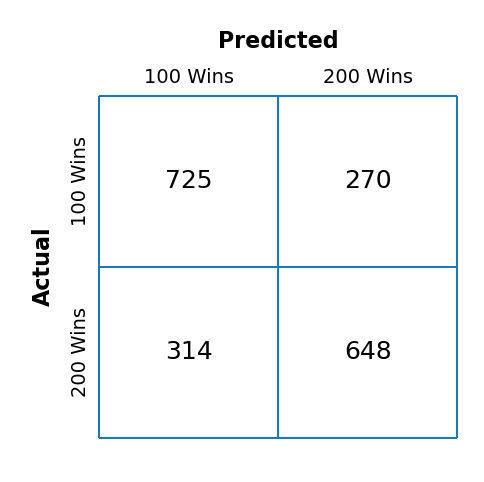

In [15]:
plot_confusion_matrix(y_test, logreg1.predict(X_test), labels = ['100 Wins', '200 Wins']);

In [16]:
accuracy_score(y_test, logreg1.predict(X_test))

0.7015840572304548

In [17]:
import matplotlib.pyplot as plt

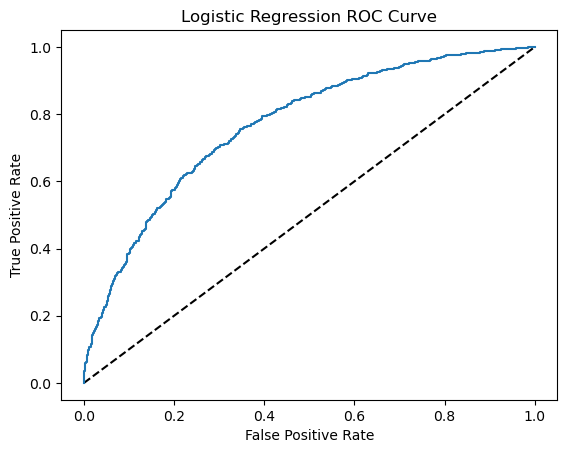

In [18]:
y_pred_probs = logreg1.predict_proba(X_test)[:, 1]
tf_y_test = y_test == 200

fpr, tpr, thresholds = roc_curve(tf_y_test, y_pred_probs)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

- Damage done, taken, gold

In [27]:
variables = ['phys_d_done_100',
             'phys_d_done_200',
             'phys_d_taken_100',
             'phys_d_taken_200',
             'total_gold_100',
             'total_gold_200',]

X = model_df[variables]

y = model_df['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, stratify = y)

logreg2 = LogisticRegression().fit(X_train, y_train)

In [28]:
logreg2.predict_proba(X_test)

array([[0.32573264, 0.67426736],
       [0.87191835, 0.12808165],
       [0.30273011, 0.69726989],
       ...,
       [0.17384845, 0.82615155],
       [0.20548989, 0.79451011],
       [0.61361911, 0.38638089]])

In [29]:
print(classification_report(y_test, logreg2.predict(X_test)))

              precision    recall  f1-score   support

         100       0.69      0.73      0.71       995
         200       0.70      0.66      0.68       962

    accuracy                           0.70      1957
   macro avg       0.70      0.70      0.70      1957
weighted avg       0.70      0.70      0.70      1957



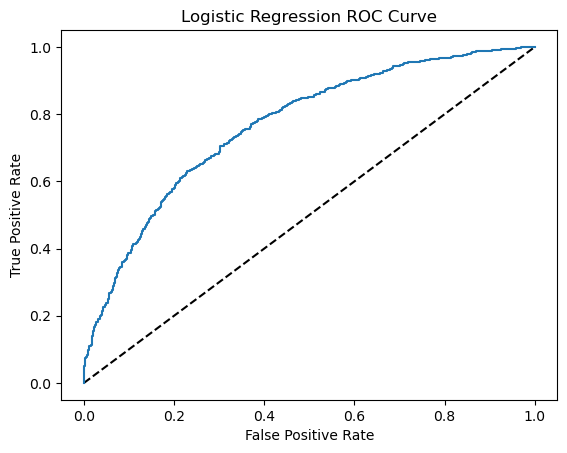

In [30]:
y_pred_probs = logreg2.predict_proba(X_test)[:, 1]
tf_y_test = y_test == 200

fpr, tpr, thresholds = roc_curve(tf_y_test, y_pred_probs)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

The first one has slightly better F1 and Recall values, so that's what we'll fit to the model

### Get preditions using test data

In [31]:
# bring in the participants data
participants_test = pd.read_csv('../data/participants_test.csv')

# bring in the champion_mastery info
champion_mastery = pd.read_csv('../data/champion_mastery.csv')

# merge champion mastery info in
df = pd.merge(participants_test, champion_mastery, on = ['championId', 'summonerId'])

# bring in stats data from the 10-minute mark
stats = pd.read_pickle('../data/test_ten_min_stats.pkl')#.drop(columns = 'Unnamed: 0')

# merge in stats
df = (
    pd.merge(df, 
             stats, 
             on = ['matchId', 'participantId'])
)

In [32]:
# aggregate team stats
test_team_stats = (
    df
    .groupby(['matchId', 'teamId'])
    .agg(champion_level = ('championLevel', 'sum'),
         champion_points = ('championPoints', 'sum'),
         total_gold = ('total_gold', 'sum'),
         total_xp = ('xp', 'sum'),
         avg_level = ('level', 'mean'),
         participants = ('participantId', 'count'))
    .reset_index()
)

In [33]:
# separate out the teams for each match so they can be put into the same row
test_team_100s = test_team_stats.loc[test_team_stats['teamId'] == 100].reset_index(drop = True)

test_team_200s = test_team_stats.loc[test_team_stats['teamId'] == 200].reset_index(drop = True)

# merge so that data for both teams is horizontally arranged
test_model_df = pd.merge(test_team_100s, test_team_200s, on = 'matchId', suffixes = ('_100', '_200'))

test_model_df

,matchId,teamId_100,champion_level_100,champion_points_100,total_gold_100,total_xp_100,avg_level_100,participants_100,teamId_200,champion_level_200,champion_points_200,total_gold_200,total_xp_200,avg_level_200,participants_200
0,8000,100,31,1359299,17313,18099,7.0,5,200,28,948274,16933,17117,6.6,5
1,8001,100,31,1147253,17492,16756,6.6,5,200,26,1220036,17533,16527,6.6,5
2,8002,100,29,378133,16206,16640,6.6,5,200,25,177408,17480,16518,6.6,5
3,8003,100,30,779781,17784,16759,6.6,5,200,23,103605,18126,17173,6.8,5
4,8004,100,27,1122145,16341,18377,6.8,5,200,27,391668,16993,17113,6.8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,9995,100,35,634293,15440,17688,6.8,5,200,25,228339,15060,17845,7.0,5
1996,9996,100,28,1197520,19123,18273,7.0,5,200,30,1615823,17433,18545,7.2,5
1997,9997,100,25,381700,14719,17211,7.0,5,200,26,2016938,17129,18888,7.0,5
1998,9998,100,30,1195684,18353,18298,7.0,5,200,30,1074708,15134,16823,6.8,5


In [35]:
variables = variables

test_X = test_model_df[variables]

submission_predictions = pd.DataFrame(logreg1.predict(test_X)).rename(columns = {0 : 'winner'})

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- champion_level_100
- champion_level_200
Feature names seen at fit time, yet now missing:
- avg_level_100
- avg_level_200
- phys_d_done_100
- phys_d_done_200
- phys_d_taken_100
- ...


In [ ]:
submission = pd.merge(test_model_df['matchId'], submission_predictions, left_index = True, right_index = True )
submission

In [ ]:
submission.to_csv('../data/submission_2023-28-03_v01.csv', index = False)